In [1]:
import pandas as pd

df = pd.read_csv("../local_artifacts/all_frames.csv")
ag_df = pd.read_csv("../local_artifacts/four_videos.csv")

In [2]:
videos = ag_df["video"].unique()
df.drop(df[df["video"].map(lambda x: x not in videos)].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [3]:
df

,video,sample,roi,frame,Volume from voxels,Average width,Std width,Total length,Volume from length
0,2024Jul28,0,1,0,0.016517,0.288864,0.261866,0.043904,0.043904
1,2024Jul28,0,1,1,0.009023,0.245230,0.252489,0.027060,0.027060
2,2024Jul28,0,1,2,0.005765,0.237166,0.228372,0.017856,0.017856
3,2024Jul28,0,1,3,0.008116,0.258085,0.251124,0.024305,0.024305
4,2024Jul28,0,1,4,0.008211,0.248712,0.254622,0.026245,0.026245
...,...,...,...,...,...,...,...,...,...
1634,2024Sep08,3,1,3,0.008815,0.428094,0.260963,0.018695,0.018695
1635,2024Sep08,3,1,4,0.014387,0.415295,0.280065,0.032050,0.032050
1636,2024Sep08,3,1,5,0.017877,0.370714,0.250894,0.048701,0.048701
1637,2024Sep08,3,1,6,0.010210,0.371508,0.241900,0.030910,0.030910


In [4]:
import numpy as np

classes = np.empty(len(df), dtype=object)

for i in range(len(df)):
    entry = ag_df[
        (ag_df["video"] == df.loc[i, "video"])
        & (ag_df["sample"] == df.loc[i, "sample"])
        & (ag_df["roi"] == df.loc[i, "roi"])]["class"]
    if len(entry) == 0:
        print(f"Missing class for {df['video'][i]} {df['sample'][i]} {df['roi'][i]}")
    else:
        classes[i] = entry.values[0]

In [5]:
df.insert(0, "class", classes)

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
classes = df["class"]
y = le.fit_transform(classes)
# X = df.drop(columns=["class", "video", "sample", "roi", "GFP"])
X = df.drop(columns=["video", "sample", "roi", "frame", "class"])
X = StandardScaler().fit_transform(X)

In [7]:
le.classes_

array(['ct', 'mu', 'wt'], dtype=object)

In [8]:
from umap import UMAP

embedding = UMAP(n_neighbors=10, min_dist=0.0).fit_transform(X)

/home/zain/micromamba/envs/tsvb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

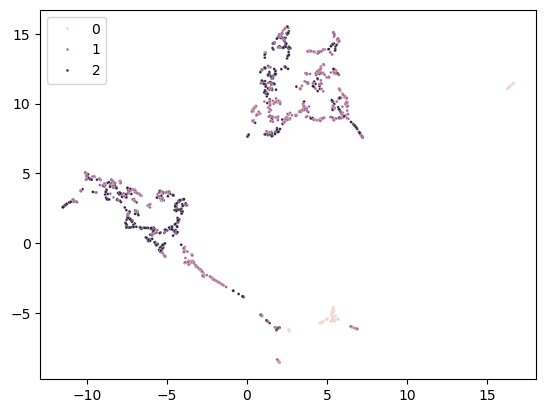

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y, s=4)

In [10]:
from PCH import HDBSCAN
from PCH.utils import augment_labels

hdb = HDBSCAN(min_cluster_size=10)
hdb.fit(X)
labels = augment_labels(X, hdb.labels_)

<Axes: >

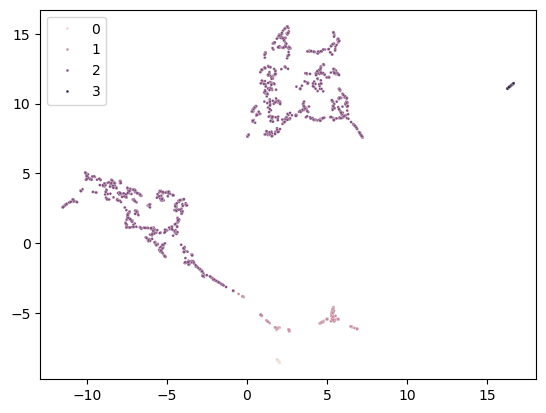

In [11]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, s=4)

In [17]:
from sklearn.metrics import (
    adjusted_rand_score,
    fowlkes_mallows_score,
    normalized_mutual_info_score,
    accuracy_score,
)


def _unsupervised_accuracy(labels_true, labels):
    assert np.unique(labels_true).size == 2
    unique_labels = np.unique(labels)
    highest_acc = 0
    for label in unique_labels:
        if np.sum(labels == label) == 0:
            continue
        acc = (
            np.sum((labels == label) & (labels_true == 1))
            + np.sum((labels != label) & (labels_true == 0))
        ) / labels_true.shape[0]
        print(f"{label=} : {acc=:.2f}")
        if acc > highest_acc:
            highest_acc = acc
    return highest_acc


def score(labels, labels_true):
    scorers = [
        adjusted_rand_score,
        fowlkes_mallows_score,
        normalized_mutual_info_score,
    ]
    if len(np.unique(labels_true)) == 2:
        scorers.append(_unsupervised_accuracy)
    for scorer in scorers:
        print(f"{scorer.__name__}: {scorer(labels_true, labels):.2f}")

In [18]:
_y = np.array([1 if c == 'mu' else 0 for c in classes])
score(labels, _y)

adjusted_rand_score: -0.03
fowlkes_mallows_score: 0.63
normalized_mutual_info_score: 0.06
label=0 : acc=0.63
label=1 : acc=0.56
label=2 : acc=0.45
label=3 : acc=0.60
_unsupervised_accuracy: 0.63


<Axes: >

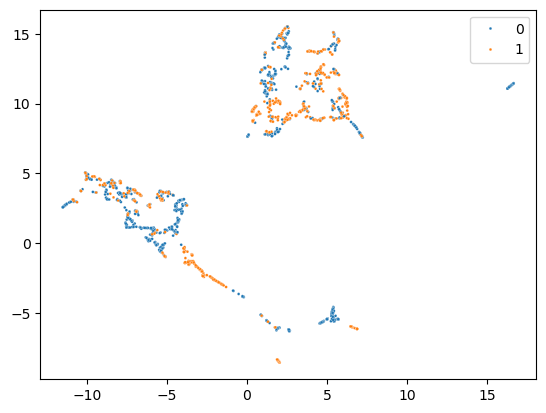

In [19]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=_y, s=4)

In [20]:
from PCH.utils import constraints_from_estimate

constraints = constraints_from_estimate(X, hdb.labels_, _y, 20)

In [21]:
hdb_t = HDBSCAN(
    min_cluster_size=100,
    min_samples=5,
    constraint_mode="t-synthetic",
)
constrained_labels = hdb_t.fit(X, constraints=constraints).labels_
constrained_labels = augment_labels(X, constrained_labels)

<Axes: >

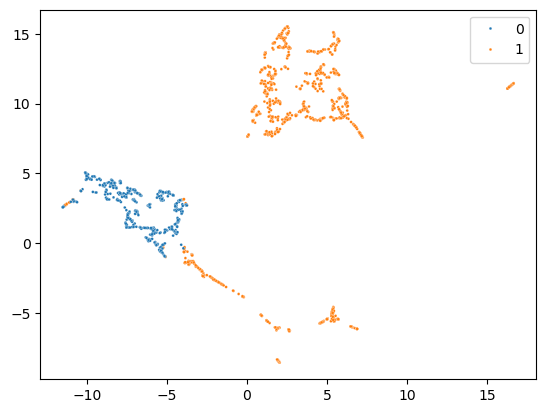

In [22]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=constrained_labels, s=4)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
score(y_pred, y_test)

              precision    recall  f1-score   support

          ct       0.96      0.96      0.96        25
          mu       0.80      0.69      0.74       131
          wt       0.79      0.87      0.83       172

    accuracy                           0.81       328
   macro avg       0.85      0.84      0.84       328
weighted avg       0.81      0.81      0.81       328

adjusted_rand_score: 0.43
fowlkes_mallows_score: 0.69
normalized_mutual_info_score: 0.46


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, _y, test_size=0.2, random_state=2)
clf = RandomForestClassifier(n_estimators=100, random_state=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["non-mutant", "mutant"]))
score(y_pred, y_test)

              precision    recall  f1-score   support

  non-mutant       0.85      0.93      0.89       209
      mutant       0.86      0.71      0.78       119

    accuracy                           0.85       328
   macro avg       0.86      0.82      0.84       328
weighted avg       0.85      0.85      0.85       328

adjusted_rand_score: 0.49
fowlkes_mallows_score: 0.78
normalized_mutual_info_score: 0.38
label=0 : acc=0.15
label=1 : acc=0.85
_unsupervised_accuracy: 0.85


In [26]:
score(labels, y)
score(constrained_labels, y)
print(f"\n\n")
score(labels, _y)
score(constrained_labels, _y)

adjusted_rand_score: 0.21
fowlkes_mallows_score: 0.68
normalized_mutual_info_score: 0.31
adjusted_rand_score: 0.02
fowlkes_mallows_score: 0.51
normalized_mutual_info_score: 0.09



adjusted_rand_score: -0.03
fowlkes_mallows_score: 0.63
normalized_mutual_info_score: 0.06
label=0 : acc=0.63
label=1 : acc=0.56
label=2 : acc=0.45
label=3 : acc=0.60
_unsupervised_accuracy: 0.63
adjusted_rand_score: 0.01
fowlkes_mallows_score: 0.55
normalized_mutual_info_score: 0.05
label=0 : acc=0.43
label=1 : acc=0.57
_unsupervised_accuracy: 0.57


In [ ]:
print(classification_report(_y, labels==2, target_names=le.classes_[:2]))

In [ ]:
def merge_constraints(current_constraints, new_constraints):
    for key in new_constraints:
        if key not in current_constraints:
            current_constraints[key] = []
        current_constraints[key].extend(new_constraints[key])
    return current_constraints

n_iters = 100
constraints = {}
for i in range(n_iters):
    constraints = merge_constraints(
        constraints,
        constraints_from_estimate(X, constrained_labels, y, 5),
    )
    constrained_labels = hdb_t.fit(X, constraints=constraints).labels_
    constrained_labels = augment_labels(X, constrained_labels)
    score(constrained_labels, y)
    print(f"Iteration {i+1}/{n_iters} complete.\n\n")